<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Desafio-NLP--Classificacao/Tweets_Covid_19_AnaliseSentimentos_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimentos (classificação) de tweets relacionados a COVID-19

### Dataset: Coronavirus tweets NLP - Text Classification - https://www.kaggle.com/datatattle/covid-19-nlp-text-classification




In [1]:
!pip install contractions

     |████████████████████████████████| 327kB 8.5MB/s 
     |████████████████████████████████| 266kB 13.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85259 sha256=660d4180270602be75f0ec9e23d135f0619ff8f7b4aa853c734192f47c5ada35
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [2]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import unicodedata
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import collections
import os
import shutil
%matplotlib inline

from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.probability import ConditionalFreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from nltk.classify import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from nltk import classify
import nltk.classify
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from bs4 import BeautifulSoup


warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=72034602e0f66cedff30cc7be1c80274421bc8f24d18179fc9cb0d01bce6ff86
  Stored in directory: /tmp/pip-ephem-wheel-cache-xbkxtbr6/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_md -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/desafio 1/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


## Pré-processamento da base

#### Carregar as bases de treino e teste

In [5]:
df_train = pd.read_csv('Corona_NLP_train.csv', engine='python')
df_test = pd.read_csv('Corona_NLP_test.csv', engine='python')

In [6]:
df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [7]:
train = len(df_train)
test = len(df_test)

print('Número de Tweets na base de treino: ', train)
print('Número de Tweets na base de test: ', test)

Número de Tweets na base de treino:  41157
Número de Tweets na base de test:  3798


In [8]:
df_train['OriginalTweet'][4]

"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"

#### Simplificar contrações e expressões

In [9]:
df_train['OriginalTweet'] = df_train.replace({'OriginalTweet': contractions_dict},regex=True)
df_test['OriginalTweet'] = df_test.replace({'OriginalTweet': contractions_dict},regex=True)                                      

#### Remover caracteres especiais e transformar os demais em minúsculos

In [10]:
def remove_special_characters(text):
  
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)

  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  text = re.sub('_', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('&amp', ' ', text)
  text = re.sub(r'[^ \\t\w\.]', '', text)
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  text = re.sub(r"\s+"," ",text).strip()
  return text

df_train['OriginalTweet'] = df_train.OriginalTweet.map(remove_special_characters).str.lower()
df_test['OriginalTweet'] = df_test.OriginalTweet.map(remove_special_characters).str.lower()

In [11]:
df_train['OriginalTweet'][4]

'me ready to go at supermarchet during the covid19 outbreak not because i am paranoid but because my food stock is litteraly thempty the coronavirus is a serious thing but please do not panic it causes shortage coronavirusfrance restezchezvous stayathome confinthement cousmualq72n'

#### Lemetização

In [12]:
#nlp = spacy.load('en')

#def lemmatize(text):
#  text = nlp(text)
#  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#  return text

#df_train['OriginalTweet'] = df_train.OriginalTweet.map(lemmatize)
#df_test['OriginalTweet'] = df_test.OriginalTweet.map(lemmatize)

#### Tokenizar

In [13]:
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

df_train['OriginalTweet'] = df_train.OriginalTweet.apply(tk.tokenize)
df_test['OriginalTweet'] = df_test.OriginalTweet.apply(tk.tokenize)

#### Remover stop words

In [14]:
stopword_list = nltk.corpus.stopwords.words('english')
new_stopwords = ['pic','twitter','com','amp']
stopword_list.extend(new_stopwords)
stopword_list.remove('no')
stopword_list.remove('not')

stop_lambda = lambda x: [y for y in x if y not in stopword_list]

df_train['OriginalTweet'] = df_train.OriginalTweet.map(stop_lambda)
df_test['OriginalTweet'] = df_test.OriginalTweet.map(stop_lambda)

In [15]:
df_train['OriginalTweet'][4]

['ready',
 'go',
 'supermarchet',
 'covid',
 '19',
 'outbreak',
 'not',
 'paranoid',
 'food',
 'stock',
 'litteraly',
 'thempty',
 'coronavirus',
 'serious',
 'thing',
 'please',
 'not',
 'panic',
 'causes',
 'shortage',
 'coronavirusfrance',
 'restezchezvous',
 'stayathome',
 'confinthement',
 'cousmualq',
 '72n']

## Análises estatísticas

#### Distribuição de tweets por Classe

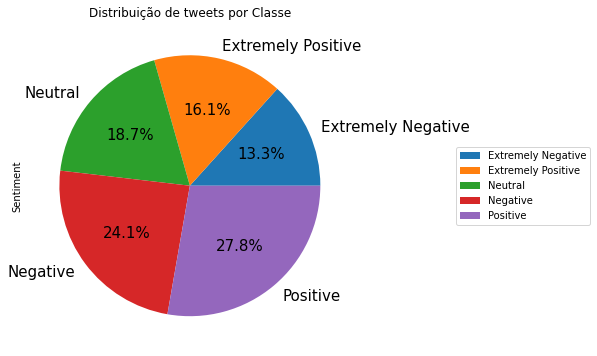

In [16]:
df_distribution = df_train.Sentiment.value_counts()\
                            .to_frame()\
                            .sort_values('Sentiment')

df_distribution.plot.pie(y='Sentiment', autopct='%1.1f%%',\
                            title='Distribuição de tweets por Classe',\
                            figsize=(6, 6), textprops = {"fontsize": 15}, labeldistance = 1.1)\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5),fontsize='medium')

plt.show;   

#### Tamanho dos tweets por classe

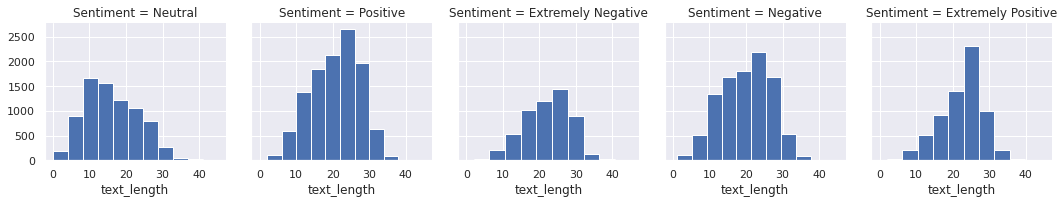

In [17]:
df_train['text_length'] = df_train.OriginalTweet.apply(len)
sns.set(font_scale = 1)
g = sns.FacetGrid(df_train,col='Sentiment')
g.map(plt.hist,'text_length')
plt.show();

#### Quantidade de caracteres nos tweets

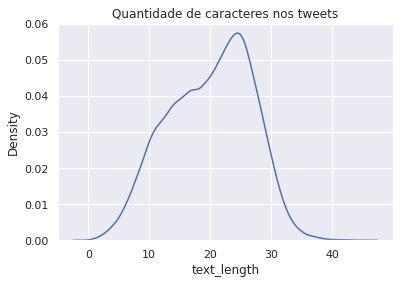

In [18]:
sns.distplot(df_train.text_length, hist=False)
plt.title('Quantidade de caracteres nos tweets')
plt.show();

#### Distribuição da quantidade de palavras nos tweets

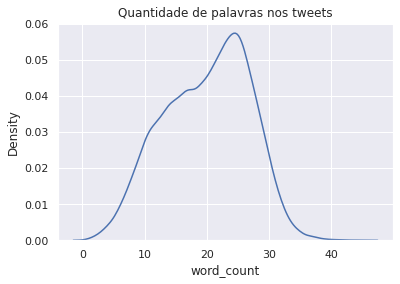

In [19]:
df_train['word_count'] = df_train.OriginalTweet.apply(lambda x: len(str(x).split()))
sns.distplot(df_train.word_count, hist=False)
plt.title('Quantidade de palavras nos tweets')
plt.show();

In [20]:
df_train.drop(['text_length',	'word_count'], axis = 1, inplace=True)

## WordCloud

In [21]:
def get_corpus(text):
  corpus = []
  words_list = []
  for row in text:
    for token in row:
      corpus.append(token)
  return corpus

In [22]:
def get_top_text_ngrams(text, n, g):
  corpus = []
  for row in text:
    words_list = []
    for item in row:
      words_list.append(item)
    item = ' '.join(words_list) 
    corpus.append(item)
  vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

### Unigrams

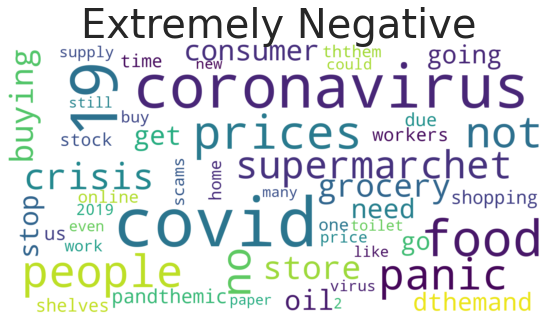

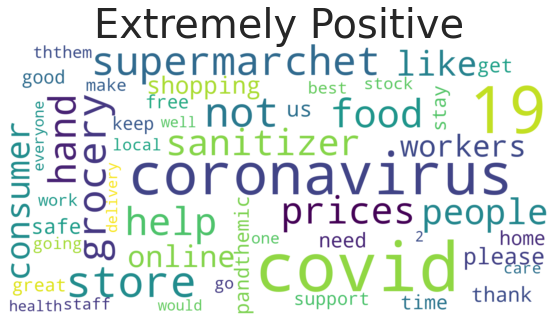

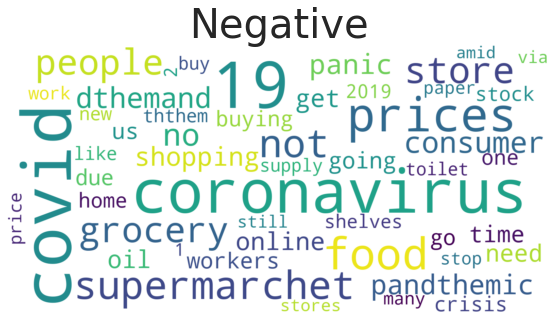

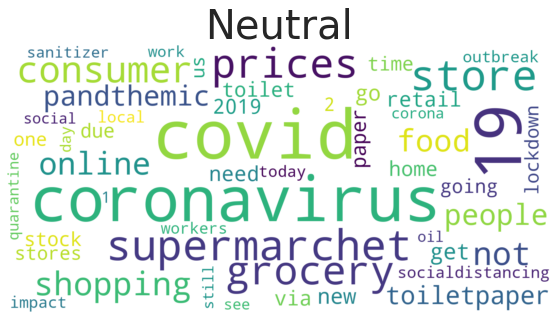

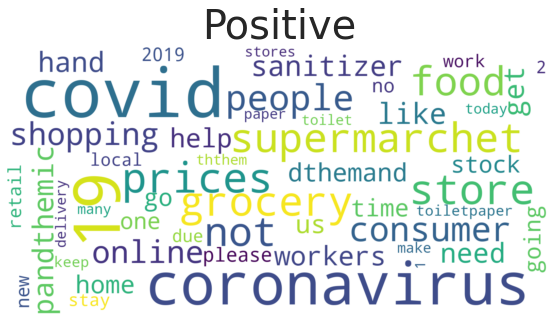

In [23]:
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    corpus = get_corpus(rows.OriginalTweet)
    counter = Counter(corpus)
    most_common = counter.most_common(50)
    most_common = dict(most_common)

  
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;  

### Bigrams

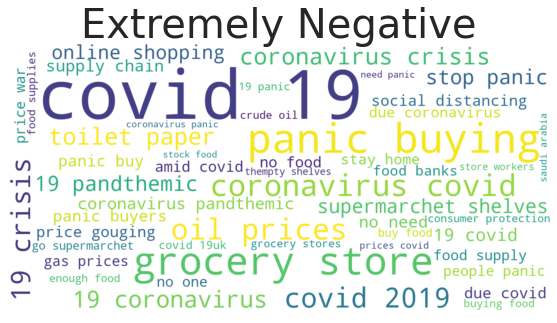

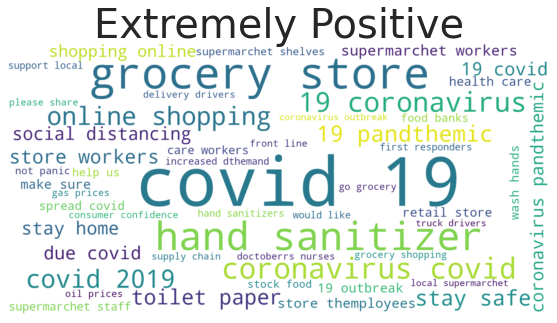

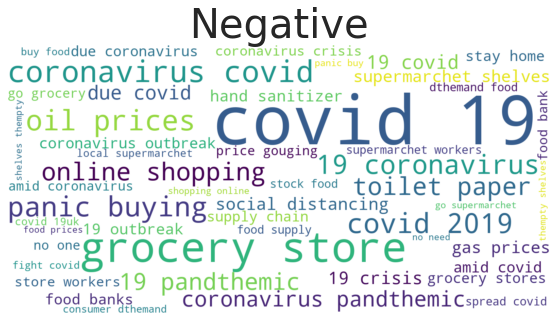

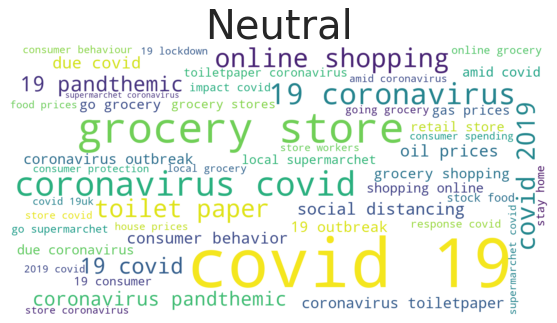

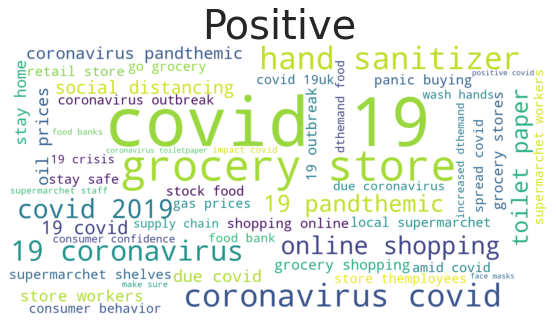

In [24]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,50,2)
    most_common = dict(most_common)
      
    ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

   

### Trigrams

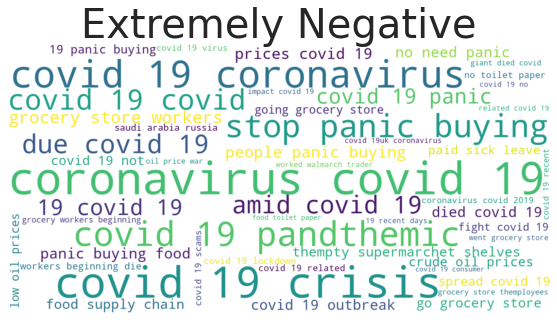

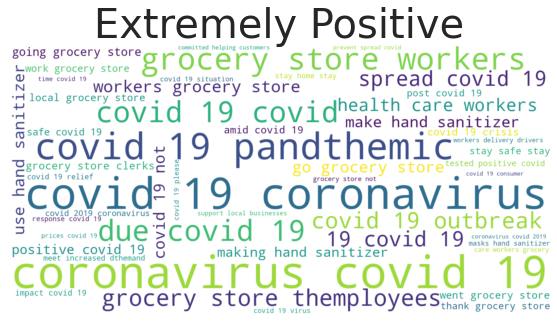

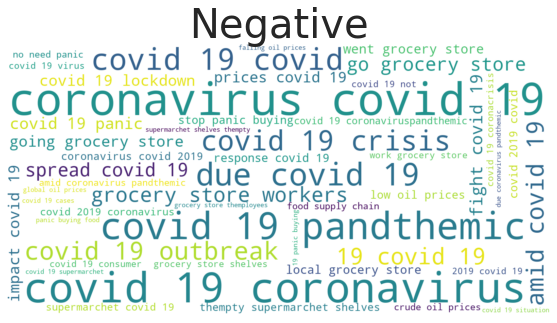

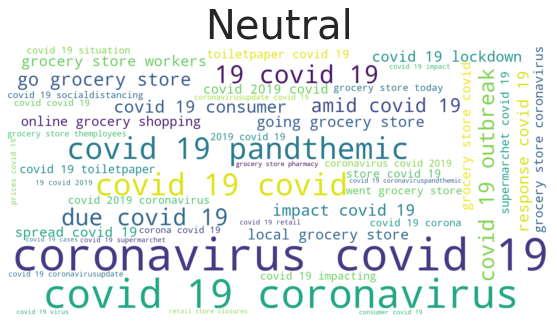

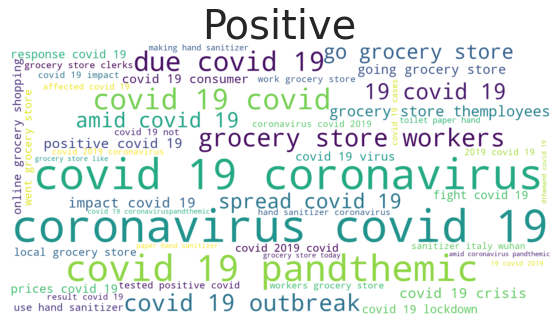

In [25]:
### Converte lista de strings em um único texto
labels = np.unique(df_train.Sentiment)
for label in labels:
    rows = df_train[df_train.Sentiment == label]
    most_common = get_top_text_ngrams(rows.OriginalTweet,50,3)
    most_common = dict(most_common)

       ## Plotagem da WordCloud       
    cloud = WordCloud(background_color='white',width=1600,height=800,\
                      max_font_size=200,max_words=50).generate_from_frequencies(most_common)

    plt.figure(figsize = (10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(label, fontsize=40)
    plt.axis('off')
    plt.show;

## Análise de Sentimentos - Classificação dos Tweets

#### Criar corpora para input nos modelos de classificação -> transformar cada linha do csv em um arquivo txt com o tweet e a categoria

In [26]:
dataset_path = '/content/drive/My Drive/desafio 1/'

In [27]:
df_corpora_train = df_train.copy()
raw_text = []
for row in df_train.OriginalTweet:
  tokens_list = []
  for item in row:
    tokens_list.append(item)
    row = ' '.join(tokens_list)
  raw_text.append(row)

df_corpora_train.insert(len(df_corpora_train.columns),'corpora', raw_text)
df_corpora_train = df_corpora_train.reset_index()

df_corpora_train.head()

,index,OriginalTweet,Sentiment,corpora
0,0,"[menyrbie, phil, gahan, chrisitv, coifz, 9fan2...",Neutral,menyrbie phil gahan chrisitv coifz 9fan2pa cox...
1,1,"[advice, talk, neighbours, family, exchange, p...",Positive,advice talk neighbours family exchange phone n...
2,2,"[coronavirus, australia, woolworths, give, eld...",Positive,coronavirus australia woolworths give elderly ...
3,3,"[food, stock, not, one, thempty, please, not, ...",Positive,food stock not one thempty please not panic en...
4,4,"[ready, go, supermarchet, covid, 19, outbreak,...",Extremely Negative,ready go supermarchet covid 19 outbreak not pa...


In [28]:
df_corpora_test = df_test.copy()
raw_text = []
for row in df_test.OriginalTweet:
  tokens_list = []
  for item in row:
    tokens_list.append(item)
    row = ' '.join(tokens_list)
  raw_text.append(row)

df_corpora_test.insert(len(df_corpora_test.columns),'corpora', raw_text)
df_corpora_test = df_corpora_test.reset_index()

df_corpora_test.head()

,index,OriginalTweet,Sentiment,corpora
0,0,"[trending, new, yorkers, encounter, thempty, s...",Extremely Negative,trending new yorkers encounter thempty superma...
1,1,"[could, not, find, hand, sanitizer, fred, meye...",Positive,could not find hand sanitizer fred meyer turne...
2,2,"[find, protect, loved, ones, coronavirus]",Extremely Positive,find protect loved ones coronavirus
3,3,"[panic, buying, hits, newyork, city, anxious, ...",Negative,panic buying hits newyork city anxious shopper...
4,4,"[toiletpaper, dunnypaper, coronavirus, coronav...",Neutral,toiletpaper dunnypaper coronavirus coronavirus...


In [29]:
def CreateCorpusFromDataFrame(corpusfolder,df):
    for index, r in df.iterrows():
        id=r['index']
        body=r['corpora']
        category=r['Sentiment']
        fname=str(category)+'_'+str(id)+'.txt'
        corpusfile=open(corpusfolder+'/'+fname,'w+')
        corpusfile.write(str(body))
        corpusfile.close()
         

In [30]:
shutil.rmtree('/content/drive/My Drive/desafio 1/train')
os.makedirs(dataset_path +'train')
CreateCorpusFromDataFrame('train',df_corpora_train) 

In [31]:
#shutil.rmtree('/content/drive/My Drive/desafio 1/test')
os.makedirs(dataset_path +'test')
CreateCorpusFromDataFrame('test',df_corpora_test)

#### Importar o corpus (arquivos txt)

In [32]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
my_corpus_train = CategorizedPlaintextCorpusReader('train/', r'.*', cat_pattern=r'(.*)_.*')
my_corpus_test =  CategorizedPlaintextCorpusReader('test/', r'.*', cat_pattern=r'(.*)_.*')

In [33]:
print('train.fileids: ',len(my_corpus_train.fileids()))
print('test.fileids: ',len(my_corpus_test.fileids()))

train.fileids:  41157
test.fileids:  3798


#### Criar dicionários de treino e test para input nos modelos

In [34]:
def create_word_features(words):
    
  useful_words = [word for word in words if word not in stopword_list]
  my_dict = dict([(word, True) for word in useful_words])
    
  return my_dict

In [35]:
def word_features_cat(corpus,cat,name):
  word_features = []
  
  for fileid in corpus.fileids(cat):
    words = corpus.words(fileid) 
    word_features.append((create_word_features(words), name))
   
  return word_features

In [36]:
extremely_negative = word_features_cat(my_corpus_train,'Extremely Negative','extremely negative')                                                                    

In [37]:
extremely_negative_test = word_features_cat(my_corpus_test,'Extremely Negative','extremely negative')

In [38]:
extremely_positive = word_features_cat(my_corpus_train,'Extremely Positive','extremely positive')

In [39]:
extremely_positive_test = word_features_cat(my_corpus_test,'Extremely Positive','extremely positive')

In [40]:
negative = word_features_cat(my_corpus_train,'Negative','negative')

In [41]:
negative_test = word_features_cat(my_corpus_test,'Negative','negative')

In [42]:
positive = word_features_cat(my_corpus_train,'Positive','positive')

In [43]:
positive_test = word_features_cat(my_corpus_test,'Positive','positive')

In [44]:
neutral = word_features_cat(my_corpus_train,'Neutral','neutral')

In [45]:
neutral_test = word_features_cat(my_corpus_test,'Neutral','neutral')

In [46]:
train_set = neutral + positive + negative + extremely_negative + extremely_positive
test_set =  neutral_test + positive_test + negative_test + extremely_negative_test + extremely_positive_test

In [47]:
train_set[3000]

({'28fy': True,
  'coronavirus': True,
  'cozxpyae': True,
  'expect': True,
  'explains': True,
  'get': True,
  'getting': True,
  'horrible': True,
  'like': True,
  'not': True,
  'pandthemic': True,
  'point': True,
  'sick': True,
  'supermarchet': True,
  'themployee': True,
  'trenches': True,
  'without': True},
 'neutral')

In [48]:
test_set[3000]

({'article': True,
  'buying': True,
  'come': True,
  'coronaviru': True,
  'dangerous': True,
  'food': True,
  'government': True,
  'headline': True,
  'horrendous': True,
  'journalism': True,
  'needy': True,
  'nowhere': True,
  'panic': True,
  'quoted': True,
  'sensible': True,
  'stock': True,
  'theheraldsun': True,
  'told': True,
  'urged': True,
  'us': True},
 'extremely negative')

#### NLTK NaiveBayesClassifier

In [49]:
model_nbc = nltk.NaiveBayesClassifier.train(train_set)
acc = nltk.classify.accuracy(model_nbc, test_set)
print("Accuracy NaiveBayesClassifier: ", acc)

Accuracy NaiveBayesClassifier:  0.37651395471300686


#### NLTK DecisionTreeClassifier

In [ ]:
model_d3 = nltk.classify.DecisionTreeClassifier.train(train_set)
acc = nltk.classify.accuracy(model_d3, test_set)
print("Accuracy DecisionTreeClassifier: ", acc)

#### NLTK SklearnClassifier

In [50]:
model_svc = nltk.classify.SklearnClassifier(LinearSVC())
model_svc.train(train_set)
acc = nltk.classify.accuracy(model_svc, test_set)
print("Accuracy SklearnClassifier: ", acc)

Accuracy SklearnClassifier:  0.5276461295418642
